In [1]:
from pyspark.sql.types import StructType, StructField, StringType, LongType
jsonSchema = StructType([
    StructField('label', StringType(), True),
    StructField('tweet_id', LongType(), True),
    StructField('tweet_text', StringType(), True)
])

#replace the file path
df=spark.read.format("json").schema(jsonSchema).load("/Users/Pavel/Documents/KULeuven/Courses/AdvancedAnalyticsinBigDataWorld/spark/data/*")

In [2]:
df.show()

+--------------+-------------------+--------------------+
|         label|           tweet_id|          tweet_text|
+--------------+-------------------+--------------------+
|        #china|1381303111222956033|https://t.co/Mz4B...|
|      #vaccine|1380298538802765827|Infectious diseas...|
|      #vaccine|1381494016211030016|Do u truly trust ...|
|        #covid|1380766615189479425|Do u use #███████...|
|        #biden|1380129673443696640|#███████ Wants #█...|
|#stopasianhate|1380973739224010757|QUEEN OF ASIA 📈?...|
|        #covid|1381746356730101760|What’s ur main fo...|
|        #biden|1380127152847347714|NO ONE WANTS TO B...|
|        #covid|1381347661396246531|Domain for sale: ...|
|        #china|1380180497062629376|Dm or comment (re...|
|        #biden|1380986061078282245|It was a lie, our...|
|        #biden|1380521381704708098|New platform Hypr...|
|        #china|1380182109097091072|Don't miss out th...|
|        #covid|1381753369576894465|The Amazing Singa...|
|        #china

## Text preprocessing

In [3]:
import pyspark.sql.functions as f
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import ltrim

#Converting all letters to lowercase
df = df.withColumn("tweet_text",f.lower(f.col("tweet_text")))

#removing punctuations, numbers, http and spaces
df =df.withColumn("tweet_text",f.regexp_replace(f.col("tweet_text"),'([^ a-zA-Z\'])',''))
df = df.withColumn("tweet_text",f.regexp_replace(f.col("tweet_text"),'http.*?\\b',' '))
df = df.withColumn("tweet_text",f.ltrim(f.regexp_replace(f.col("tweet_text"),'[\r\n\t\f\v ]+', ' ')))



In [4]:
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover

#Splitting words
tokenizer = Tokenizer(inputCol="tweet_text", outputCol="words")
dataset = tokenizer.transform(df)


In [5]:
#Lemmatization
import nltk
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
#just to try if it works
print(lemmatizer.lemmatize("bats"))
print(lemmatizer.lemmatize("are"))
print(lemmatizer.lemmatize("feet"))
print(lemmatizer.lemmatize("stocks"))

bat
are
foot
stock


In [6]:
## Didn't manage to apply lemmatization while using WordNetLemmatizer on pyspark dataframe. 
#So temporarily to make it work, firstly changed to pandas dataframe and then back to pyspark dataframe.

In [7]:
pandas_df = dataset.select("*").toPandas()

In [8]:

pandas_df['lemmatized'] = pandas_df['words'].apply(
                    lambda lst:[lemmatizer.lemmatize(word) for word in lst])
pandas_df['lemmatized']

0        [could, be, a, messan, all, out, war, of, the,...
1        [infectious, disease, designated, bed, drastic...
2                         [do, u, truly, trust, safety, i]
3                                          [do, u, use, q]
4                   [want, but, get, amp, a, dominates, u]
                               ...                        
19405                                          [on, break]
19406                                      [so, bored, of]
19407                                           [get, the]
19408                                         [is, boring]
19409                                          [fuck, you]
Name: lemmatized, Length: 19410, dtype: object

In [9]:
pandas_df

,label,tweet_id,tweet_text,words,lemmatized
0,#china,1381303111222956033,could be a messan all out war of the worlds,"[could, be, a, messan, all, out, war, of, the,...","[could, be, a, messan, all, out, war, of, the,..."
1,#vaccine,1380298538802765827,infectious disease designated bed drastic decr...,"[infectious, disease, designated, bed, drastic...","[infectious, disease, designated, bed, drastic..."
2,#vaccine,1381494016211030016,do u truly trust safety i,"[do, u, truly, trust, safety, i]","[do, u, truly, trust, safety, i]"
3,#covid,1380766615189479425,do u use q,"[do, u, use, q]","[do, u, use, q]"
4,#biden,1380129673443696640,wants but gets amp as dominates us,"[wants, but, gets, amp, as, dominates, us]","[want, but, get, amp, a, dominates, u]"
...,...,...,...,...,...
19405,#covid,1380355561615548416,on break,"[on, break]","[on, break]"
19406,#covid,1381332172846604288,so bored of,"[so, bored, of]","[so, bored, of]"
19407,#vaccine,1381191756922810370,get the,"[get, the]","[get, the]"
19408,#biden,1380189452115542019,is boring,"[is, boring]","[is, boring]"


In [10]:
dataset2 = spark.createDataFrame(pandas_df)

In [11]:
dataset2.show()

+--------------+-------------------+--------------------+--------------------+--------------------+
|         label|           tweet_id|          tweet_text|               words|          lemmatized|
+--------------+-------------------+--------------------+--------------------+--------------------+
|        #china|1381303111222956033|could be a messan...|[could, be, a, me...|[could, be, a, me...|
|      #vaccine|1380298538802765827|infectious diseas...|[infectious, dise...|[infectious, dise...|
|      #vaccine|1381494016211030016|do u truly trust ...|[do, u, truly, tr...|[do, u, truly, tr...|
|        #covid|1380766615189479425|         do u use q |     [do, u, use, q]|     [do, u, use, q]|
|        #biden|1380129673443696640|wants but gets am...|[wants, but, gets...|[want, but, get, ...|
|#stopasianhate|1380973739224010757|      queen of asia |   [queen, of, asia]|   [queen, of, asia]|
|        #covid|1381746356730101760|whats ur main for...|[whats, ur, main,...|[whats, ur, main,...|


In [12]:
#Removing stop words
stopwordList = ["u","ur", "amp", "q"] 
stopwordList.extend(StopWordsRemover().getStopWords())
remover = StopWordsRemover(inputCol="lemmatized", outputCol="filtered" ,stopWords=stopwordList)
dataset2 = remover.transform(dataset2)
dataset2.show()

+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|         label|           tweet_id|          tweet_text|               words|          lemmatized|            filtered|
+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|        #china|1381303111222956033|could be a messan...|[could, be, a, me...|[could, be, a, me...|[messan, war, world]|
|      #vaccine|1380298538802765827|infectious diseas...|[infectious, dise...|[infectious, dise...|[infectious, dise...|
|      #vaccine|1381494016211030016|do u truly trust ...|[do, u, truly, tr...|[do, u, truly, tr...|[truly, trust, sa...|
|        #covid|1380766615189479425|         do u use q |     [do, u, use, q]|     [do, u, use, q]|               [use]|
|        #biden|1380129673443696640|wants but gets am...|[wants, but, gets...|[want, but, get, ...|[want, get, domin...|
|#stopasianhate|1380973739224010

In [13]:
#to get rid of words like v, q, wa
dataset2 = dataset2.withColumn("filtered2", f.expr("filter(filtered, x -> not(length(x) < 3))")).where(f.size(f.col("filtered2")) > 0).drop("filtered")
dataset2.show(truncate = False)

+--------------+-------------------+------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------+
|label         |tweet_id           |tweet_text                                                                                                        |words                                                                                                                             |lemmatized                                                                                                                        |filtered2                                                     

In [14]:
dataset2.select("filtered2").show(truncate = False)

+--------------------------------------------------------------------------------------------------------------+
|filtered2                                                                                                     |
+--------------------------------------------------------------------------------------------------------------+
|[messan, war, world]                                                                                          |
|[infectious, disease, designated, bed, drastic, decreasejapan]                                                |
|[truly, trust, safety]                                                                                        |
|[use]                                                                                                         |
|[want, get, dominates]                                                                                        |
|[queen, asia]                                                                                  

## Bag of words

In [15]:
#Vectorizing
from pyspark.ml.feature import CountVectorizer, StringIndexer
from pyspark.ml import Pipeline

cv = CountVectorizer(inputCol="filtered2", outputCol="features")
label_stringIdx = StringIndexer(inputCol = "label", outputCol = "labelIndex")

pipeline = Pipeline(stages=[cv, label_stringIdx])

pipelineFit = pipeline.fit(dataset2)
dataset2= pipelineFit.transform(dataset2)
dataset2.show()

+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|         label|           tweet_id|          tweet_text|               words|          lemmatized|           filtered2|            features|labelIndex|
+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|        #china|1381303111222956033|could be a messan...|[could, be, a, me...|[could, be, a, me...|[messan, war, world]|(34641,[20,135,34...|       2.0|
|      #vaccine|1380298538802765827|infectious diseas...|[infectious, dise...|[infectious, dise...|[infectious, dise...|(34641,[346,612,3...|       1.0|
|      #vaccine|1381494016211030016|do u truly trust ...|[do, u, truly, tr...|[do, u, truly, tr...|[truly, trust, sa...|(34641,[389,693,1...|       1.0|
|        #covid|1380766615189479425|         do u use q |     [do, u, use, q]|    

## Train and test split

In [16]:
(trainingData2, testData2) = dataset2.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData2.count()))
print("Test Dataset Count: " + str(testData2.count()))

Training Dataset Count: 13500
Test Dataset Count: 5877


## Logistic Regression

In [17]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol = "labelIndex", featuresCol = "features", maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData2)
lrPredictions = lrModel.transform(testData2)

In [19]:
lrPredictions.select("prediction", "labelIndex").show()

+----------+----------+
|prediction|labelIndex|
+----------+----------+
|       4.0|       4.0|
|       4.0|       4.0|
|       4.0|       4.0|
|       4.0|       4.0|
|       4.0|       4.0|
|       4.0|       4.0|
|       0.0|       4.0|
|       4.0|       4.0|
|       1.0|       4.0|
|       4.0|       4.0|
|       4.0|       4.0|
|       0.0|       4.0|
|       0.0|       4.0|
|       3.0|       4.0|
|       1.0|       4.0|
|       0.0|       4.0|
|       2.0|       4.0|
|       0.0|       4.0|
|       0.0|       4.0|
|       1.0|       4.0|
+----------+----------+
only showing top 20 rows



In [20]:
import pyspark.sql.functions as col
lrPredictions.groupBy("prediction").count().orderBy(f.col("count").desc()).show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 2231|
|       1.0| 1552|
|       2.0|  950|
|       3.0|  596|
|       4.0|  523|
|       5.0|   25|
+----------+-----+



In [24]:
from pyspark.ml.feature import IndexToString, StringIndexer
converter = IndexToString(inputCol="labelIndex", outputCol="labelOriginal")
converted = converter.transform(lrPredictions)


In [29]:
converter = IndexToString(inputCol="prediction", outputCol="predictionOriginal")
converted = converter.transform(lrPredictions)

Py4JJavaError: An error occurred while calling o435.transform.
: java.util.NoSuchElementException: None.get
	at scala.None$.get(Option.scala:529)
	at scala.None$.get(Option.scala:527)
	at org.apache.spark.ml.feature.IndexToString.transform(StringIndexer.scala:605)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)


In [28]:
converted.select("label", "labelIndex", "labelOriginal").show(1000)

+--------------+----------+--------------+
|         label|labelIndex| labelOriginal|
+--------------+----------+--------------+
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #biden|       4.0|        #biden|
|        #b

### Evaluation

In [29]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(lrPredictions)
print(accuracy)
print("Test Error = %g " % (1.0 - accuracy))

0.6309341500765697
Test Error = 0.369066 


In [30]:
trainingSummary = lrModel.summary

print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

False positive rate by label:
label 0: 0.04056690972578823
label 1: 0.021245634458672877
label 2: 0.0033966767648948865
label 3: 0.00043047783039173483
label 4: 0.0017908920347944738
label 5: 0.0
True positive rate by label:
label 0: 0.9707680042519267
label 1: 0.9536340852130326
label 2: 0.956271576524741
label 3: 0.9458885941644563
label 4: 0.9137542277339347
label 5: 0.8207885304659498
Precision by label:
label 0: 0.9024209486166008
label 1: 0.9328838492185105
label 2: 0.9853754940711462
label 3: 0.9972035794183445
label 4: 0.98721071863581
label 5: 1.0
Recall by label:
label 0: 0.9707680042519267
label 1: 0.9536340852130326
label 2: 0.956271576524741
label 3: 0.9458885941644563
label 4: 0.9137542277339347
label 5: 0.8207885304659498
F-measure by label:
label 0: 0.9353475867366535
label 1: 0.943144848954299
label 2: 0.970605411718902
label 3: 0.9708684998638716
label 4: 0.9490632318501171
label 5: 0.9015748031496064
Accuracy: 0.9498518518518518
FPR: 0.017282442666394057
TPR: 0.94985

In [31]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

In [32]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Make predicitons
predictionAndTarget = lrPredictions.select("prediction", "labelIndex")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndTarget)

In [33]:
evaluatorMulti.evaluate(predictionAndTarget) #gives F1 score


0.6336097904544756

In [34]:
print("ACC: %s" % acc)
print("F1 score: %s" % f1)
print("Weighted Precision: %s" % weightedPrecision)
print("Weighted Recall: %s" % weightedRecall)
print("AUC: %s" % auc)

ACC: 0.6309341500765697
F1 score: 0.6336097904544756
Weighted Precision: 0.6692993502435791
Weighted Recall: 0.6309341500765697
AUC: 0.6309341500765697


In [36]:
# Overall statistics
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

# Statistics by class
labels = data.map(lambda lp: lp.label).distinct().collect()
for label in sorted(labels):
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))

# Weighted stats
print("Weighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

NameError: name 'metrics' is not defined

In [ ]:
# this part does not work for now

trainingSummary = lrModel.summary

# Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)
# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('threshold').head()['threshold']
# lr.setThreshold(bestThreshold)

In [ ]:
print("Coefficients: \n" + str(lrModel.coefficientMatrix))

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
class_temp = lrPredictions.select("labelIndex").groupBy("labelIndex").count().sort('count', ascending=False).toPandas()
class_temp = class_temp["labelIndex"].values.tolist()
class_names = map(str, class_temp)
#print(class_name)
class_names

In [41]:
from sklearn.metrics import confusion_matrix
y_true = lrPredictions.select("labelIndex")
y_true = y_true.toPandas()

y_pred = lrPredictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix


array([[1158,  389,   68,   19,   31,    1],
       [ 410,  867,   41,    3,   18,    0],
       [ 268,  120,  706,   18,   38,    1],
       [ 154,   59,   27,  540,   14,    0],
       [ 191,   98,   87,   15,  415,    1],
       [  50,   19,   21,    1,    7,   22]])

Confusion matrix, without normalization
[[1158  389   68   19   31    1]
 [ 410  867   41    3   18    0]
 [ 268  120  706   18   38    1]
 [ 154   59   27  540   14    0]
 [ 191   98   87   15  415    1]
 [  50   19   21    1    7   22]]


TypeError: object of type 'map' has no len()

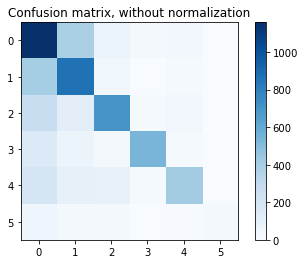

In [42]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[6.95078031e-01 2.33493397e-01 4.08163265e-02 1.14045618e-02
  1.86074430e-02 6.00240096e-04]
 [3.06198656e-01 6.47498133e-01 3.06198656e-02 2.24047797e-03
  1.34428678e-02 0.00000000e+00]
 [2.32841008e-01 1.04257168e-01 6.13379670e-01 1.56385752e-02
  3.30147698e-02 8.68809731e-04]
 [1.93954660e-01 7.43073048e-02 3.40050378e-02 6.80100756e-01
  1.76322418e-02 0.00000000e+00]
 [2.36679058e-01 1.21437423e-01 1.07806691e-01 1.85873606e-02
  5.14250310e-01 1.23915737e-03]
 [4.16666667e-01 1.58333333e-01 1.75000000e-01 8.33333333e-03
  5.83333333e-02 1.83333333e-01]]


TypeError: object of type 'map' has no len()

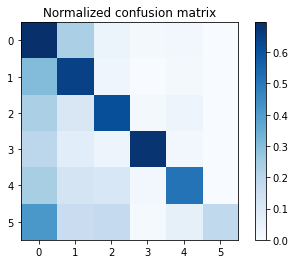

In [43]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()